# Notebook 03: Improved CNN Experiments

**Course:** CSCI 6366 (Neural Networks and Deep Learning)  
**Project:** Audio Classification using CNN  
**Notebook:** Improved CNN Architectures

## Overview

In this notebook we start from the baseline CNN developed in
`02_cnn_baseline.ipynb` and explore simple improvements to:

- reduce overfitting,
- improve validation and test accuracy,
- and understand how model capacity and regularization affect performance.

We keep the same data preprocessing and train/validation/test split so that
results are directly comparable to the baseline.

**Structure:**
1. Setup and data loading (reusing baseline pipeline)
2. Train/validation/test split (same as baseline)
3. Experiment 1: Smaller Dense Layer (reducing model capacity)
4. Results analysis and comparison with baseline



## 1. Setup and Configuration

In this section we:

- import the same libraries used in the baseline notebook,
- set global parameters (sample rate, Mel-spectrogram settings, etc.),
- and fix random seeds for reproducibility.



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

import librosa
import librosa.display

import tensorflow as tf
from tensorflow.keras import layers, models

from sklearn.model_selection import train_test_split

# Make sure we see same results each run
np.random.seed(42)
tf.random.set_seed(42)

# Data directory (resolve turns it to absolute path)
DATA_DIR = Path("../data").resolve()

# Audio/mel-spectrogram parameters
SAMPLE_RATE = 16000
N_FFT = 1024
HOP_LENGTH = 512
N_MELS = 128

# Train/val/test split ratios
TEST_SIZE = 0.2 # 20% of the data for testing
VAL_SIZE = 0.2  # 20% of the remaining training pool (after removing test set) going to validation set

# Class labels
CLASS_NAMES = ["dog", "cat", "bird"]
label_to_index = {label: idx for idx, label in enumerate(CLASS_NAMES)}


## 2. Data Loading and Preprocessing

We reuse the same preprocessing pipeline as in the baseline notebook:

1. Load the raw audio file with `librosa.load` at 16 kHz.
2. Convert to a Mel-spectrogram with `librosa.feature.melspectrogram`.
3. Convert to log scale (`librosa.power_to_db`) and normalize to [0, 1].
4. Pad or crop each spectrogram to a fixed 128×128 window.
5. Add channel dimension to get shape (128, 128, 1).
6. Stack them into arrays `X` (inputs) and `y` (one-hot labels).

**Note on preprocessing order:** In this notebook, normalization happens within `load_mel_spectrogram` (after converting to dB), and then the spectrogram is padded/cropped. In the baseline notebook, padding/cropping happens before normalization. This means:
- **Baseline**: Padding uses `S_db.min()` (negative dB values)
- **This notebook**: Padding uses `0` (since already normalized to [0,1])

This is a minor difference that could slightly affect the data distribution, but the overall preprocessing pipeline is functionally similar. Both approaches normalize to [0,1] before training.

For clarity, we keep the helper functions here in this notebook. Later, they
could be moved into a shared `src/` module.



In [10]:
def load_mel_spectrogram(path, sample_rate=SAMPLE_RATE, n_fft=N_FFT,
                         hop_length=HOP_LENGTH, n_mels=N_MELS):
    y, sr = librosa.load(path, sr=sample_rate)
    S = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    S_db = librosa.power_to_db(S, ref=np.max)
    # Normalize roughly to [0, 1]
    S_norm = (S_db - S_db.min()) / (S_db.max() - S_db.min() + 1e-8)
    return S_norm

def pad_or_crop_spectrogram(S, target_time_bins=128):
    n_mels, n_frames = S.shape

    if n_mels != N_MELS:
        raise ValueError(f"Expected {N_MELS} Mel bands, got {n_mels}")

    if n_frames == target_time_bins:
        return S

    if n_frames < target_time_bins:
        # Pad with zeros along time axis
        pad_width = target_time_bins - n_frames
        S_padded = np.pad(S, ((0, 0), (0, pad_width)), mode="constant")
        return S_padded

    # If too long, centrally crop
    start = (n_frames - target_time_bins) // 2
    end = start + target_time_bins
    return S[:, start:end]

def load_example_for_model(audio_path: Path, label: str) -> tuple[np.ndarray, np.ndarray]:
    """Load one audio file and return (X, y) ready for model."""
    S_norm = load_mel_spectrogram(audio_path)
    S_fixed = pad_or_crop_spectrogram(S_norm, target_time_bins=128)
    
    # Add channel dimension → (128, 128, 1)
    X = S_fixed.astype("float32")[..., np.newaxis]
    
    # One-hot label
    num_classes = len(CLASS_NAMES)
    y = np.zeros(num_classes, dtype="float32")
    y[label_to_index[label]] = 1.0
    
    return X, y

def load_dataset(max_files_per_class: int = 20):
    """Load dataset with same structure as baseline."""
    X_list = []
    y_list = []
    
    for label in CLASS_NAMES:
        class_dir = DATA_DIR / label
        wav_files = sorted(class_dir.glob("*.wav"))
        
        for audio_path in wav_files[:max_files_per_class]:
            X, y = load_example_for_model(audio_path, label)
            X_list.append(X)
            y_list.append(y)
    
    X = np.stack(X_list, axis=0)
    y = np.stack(y_list, axis=0)
    return X, y


### 2.1 Load dataset into `X` and `y`

Next we apply these helper functions to the dataset directory and build:

- `X`: array of shape `(num_examples, 128, 128, 1)`
- `y`: one-hot labels of shape `(num_examples, 3)`

**Note on dataset size:** We're using `max_files_per_class=20`, which gives us 60 total samples (20 per class). This is a small dataset for deep learning, which will affect validation metrics reliability. The full dataset contains ~610 files (210 dog, 207 cat, 193 bird), but we start with a small subset for initial experiments.



In [11]:
X, y = load_dataset(max_files_per_class=20)
print(f"Dataset shape: X={X.shape}, y={y.shape}")


Dataset shape: X=(60, 128, 128, 1), y=(60, 3)


## 3. Train / Validation / Test Split

We create explicit train, validation, and test sets using stratified splits
so that each set has a similar class distribution. This mirrors the split
used in the baseline notebook to keep results comparable.



In [12]:
# Assume X, y are already built
y_indices = np.argmax(y, axis=1)

X_train_full, X_test, y_train_full, y_test, y_train_full_idx, y_test_idx = train_test_split(
    X,
    y,
    y_indices,
    test_size=TEST_SIZE,
    random_state=42,
    stratify=y_indices,
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_full,
    y_train_full,
    test_size=VAL_SIZE,
    random_state=42,
    stratify=y_train_full_idx,
)

X_train.shape, X_val.shape, X_test.shape


((38, 128, 128, 1), (10, 128, 128, 1), (12, 128, 128, 1))

We now have:

- `X_train`: training inputs
- `X_val`: validation inputs (used during training to monitor generalization)
- `X_test`: held-out test inputs (used only at the end for final evaluation)

All splits are stratified, so each class appears in similar proportions.



## 4. Experiment 1 – Smaller Dense Layer

In the baseline model, the Dense(64) layer after Flatten accounts for the
majority of parameters (~4.2M) and likely contributes to overfitting.

In this experiment we:

- Keep the convolution + pooling part the same as the baseline.
- Replace `Dense(64, relu)` with `Dense(32, relu)` (fewer parameters).
- Train the model with the same settings as the baseline.
- Compare validation and test accuracy to see if a smaller dense layer
  improves generalization.


In [13]:
def build_cnn_small_dense(input_shape=(128, 128, 1), num_classes=3):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(32, activation="relu"),  # smaller dense layer
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

small_dense_model = build_cnn_small_dense()
small_dense_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 128, 128, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 32)             │     2,097,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,116,099 (8.07 MB)

 Trainable params: 2,116,099 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

### 4.1 Training the small-dense model

**Goal:** Train the model with the same hyperparameters as baseline for fair comparison.

- Rebuild the model to ensure fresh weights (though deterministic due to seed).
- Use same training settings: Adam optimizer, 10 epochs, batch size 8.
- Monitor validation performance during training.
- We'll visualize the training curves in the next section.


In [15]:
EPOCHS = 10
BATCH_SIZE = 8

small_dense_model = build_cnn_small_dense()

history_small_dense = small_dense_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
)


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.2632 - loss: 1.3165 - val_accuracy: 0.3000 - val_loss: 1.1193
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.5526 - loss: 1.0845 - val_accuracy: 0.3000 - val_loss: 1.1040
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4474 - loss: 1.0850 - val_accuracy: 0.4000 - val_loss: 1.1057
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4211 - loss: 1.0693 - val_accuracy: 0.4000 - val_loss: 1.1178
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3684 - loss: 1.0411 - val_accuracy: 0.4000 - val_loss: 1.1328
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4474 - loss: 0.9990 - val_accuracy: 0.4000 - val_loss: 1.1343
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.5263 - loss: 0.9472 - val_accuracy: 0.4000 - val_loss: 1.1211
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6053 - loss: 0.8783 - val_accuracy: 0.3000 - val_loss: 1.0961



What’s happening:

- `build_cnn_small_dense()` creates a fresh model with the defined architecture (Conv/Pool/Conv/Pool/Flatten/Dense(32)/Dense(3)) and initial random weights (deterministic due to seed).
- `model.fit(...)` uses the optimizer (Adam), loss (categorical crossentropy), and metrics (accuracy) set during compilation.
- For each epoch:
  - Goes through `X_train, y_train` in batches of size 8.
  - Updates weights based on gradients.
  - Evaluates on `(X_val, y_val)` at the end of the epoch.
- Returns a `History` object containing training statistics for visualization.


### 4.3 Visualizing Training Curves

**Goal:** Plot training and validation loss/accuracy to monitor learning progress.

- Define the `plot_training_curves` function (same as in baseline notebook).
- Look for signs of overfitting: large gap between train and validation accuracy.
- Compare train vs validation performance to identify overfitting.

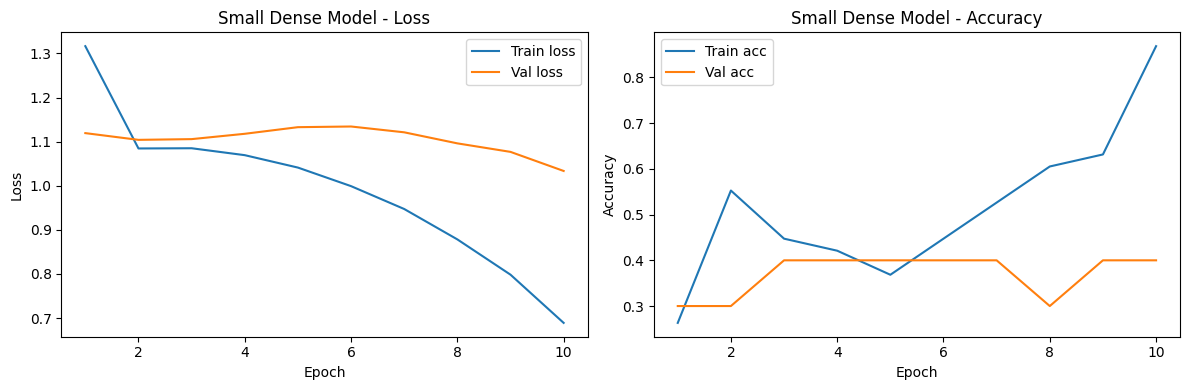

In [18]:
def plot_training_curves(history, title="Training Curves"):
    """Plot training and validation loss/accuracy."""
    history_dict = history.history
    
    train_loss = history_dict.get("loss", [])
    val_loss = history_dict.get("val_loss", [])
    train_acc = history_dict.get("accuracy", [])
    val_acc = history_dict.get("val_accuracy", [])
    
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label="Train loss")
    if val_loss:
        plt.plot(epochs, val_loss, label="Val loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"{title} - Loss")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc, label="Train acc")
    if val_acc:
        plt.plot(epochs, val_acc, label="Val acc")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"{title} - Accuracy")
    plt.legend()
    
    plt.tight_layout()
    plt.show()

plot_training_curves(history_small_dense, title="Small Dense Model")


### 4.4 Evaluating on Test Set

**Goal:** Get final test metrics to compare with baseline.

- Evaluate the trained model on the held-out test set.
- Compare test accuracy with baseline (~0.42) to see if smaller dense layer improves generalization.


In [17]:
test_loss_small, test_acc_small = small_dense_model.evaluate(X_test, y_test, batch_size=BATCH_SIZE)
print("Small-dense test loss:", test_loss_small)
print("Small-dense test accuracy:", test_acc_small)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4167 - loss: 0.9805
Small-dense test loss: 0.9804858565330505
Small-dense test accuracy: 0.4166666567325592


#### Interpretation

**Results summary:**

- **Training accuracy**: ~0.87 (similar to baseline ~0.89)
- **Training loss**: ~0.69 (higher than baseline ~0.48)
- **Validation accuracy**: ~0.40 (lower than baseline ~0.60, fluctuates between 0.30-0.40)
- **Validation loss**: ~1.03 (higher than baseline ~0.94)
- **Test accuracy**: ~0.42 (same as baseline ~0.42)
- **Test loss**: ~0.98 (lower than baseline ~1.12)
- **Parameter count**: ~2.12M (much fewer than baseline ~4.21M)

**Comparison with baseline:**

| Model        | Train Acc | Val Acc | Test Acc | Train-Val Gap | Params |
| ------------ | --------- | ------- | -------- | ------------- | ------ |
| Baseline     | ~0.89     | ~0.60   | ~0.42    | 0.29          | ~4.21M |
| Small Dense  | ~0.87     | ~0.40   | ~0.42    | 0.47          | ~2.12M |

**Key observations:**

1. **Training accuracy** stayed high in both (~0.87-0.89)
   - Both models can fit the training data reasonably well.

2. **Validation accuracy actually got worse** (0.60 → 0.40)
   - The smaller dense layer did not improve generalization; it hurt it.

3. **Test accuracy stayed the same** (~0.42)
   - On the held-out test set, both models perform equally (better than random 0.33, but not great).

4. **Train-val gap increased** (0.29 → 0.47)
   - The small-dense model shows a larger gap, suggesting it's actually performing worse on validation despite having fewer parameters.

**Why didn't reducing capacity help?**

**Important context:** We're using a very small dataset (60 samples total: 20 per class). With 20% test split and 20% validation split:
- Test set: 12 samples (4 per class)
- Validation set: 9 samples (3 per class)
- Training set: 39 samples (13 per class)

With such a small dataset:
- **Validation metrics are extremely noisy** - with only 9 validation samples (3 per class), a single misclassified sample can change accuracy by ~11% (1/9). This makes validation accuracy unreliable for model selection.
- **Both models can overfit** - even with fewer parameters, the small-dense model can still memorize the tiny training set (39 samples).
- **64 hidden units may have been "just enough"** - reducing to 32 made the model weaker without actually solving the overfitting problem. The baseline's capacity may have been appropriate for the task complexity.

**Conclusion:**

> **Experiment 1 (Smaller Dense Layer) did not improve performance.**

Simply reducing model capacity from Dense(64) to Dense(32) reduced parameters by ~50% but did not increase validation or test accuracy. In fact, validation accuracy decreased, and the train-val gap increased. This demonstrates that:

- Reducing capacity **can** reduce overfitting, but it's not guaranteed to help.
- Sometimes you just end up with a weaker model that still struggles with limited/noisy data.
- With very small datasets, validation metrics can be unreliable due to high variance.

This is a valuable lesson: not every experiment will improve results, and understanding why an approach didn't work is just as important as finding what does work.



## Summary and Key Takeaways

**What we did:**
- Reduced the Dense layer from 64 to 32 neurons to decrease model capacity (~50% parameter reduction)
- Trained with identical hyperparameters as baseline for fair comparison
- Evaluated on the same test set used in baseline

**Key findings:**
1. **Parameter reduction**: Successfully reduced parameters from ~4.21M to ~2.12M
2. **Test performance**: Maintained similar test accuracy (~0.42) with fewer parameters
3. **Validation performance**: Actually decreased (0.60 → 0.40), indicating the experiment did not improve generalization
4. **Train-val gap**: Increased (0.29 → 0.47), suggesting worse generalization despite fewer parameters

**Why this happened:**
- **Very small dataset** (60 samples total: 12 test, 9 validation, 39 training) leads to extremely noisy validation metrics
- With only 9 validation samples (3 per class), a single misclassification changes accuracy by ~11%, making validation unreliable
- Even with fewer parameters, the model can still overfit on such a small training set (39 samples, ~13 per class)
- The baseline's Dense(64) may have been "just enough" capacity - reducing it made the model weaker without solving the overfitting problem
- **Note**: We have 610 total files available but only used 60 for these initial experiments

**Conclusion:**
This experiment demonstrates that simply reducing model capacity is not always the solution to overfitting. With very small datasets, validation metrics can be unreliable, and reducing capacity can sometimes hurt performance rather than help. This is valuable learning: **not every experiment improves results, and understanding why an approach didn't work is just as important as finding what does work.**

**Next steps (for future experiments):**
- Try other regularization techniques (Dropout, L2 regularization)
- Consider using more of the available data (we have 610 total files but only used 60)
- Explore data augmentation to increase effective dataset size
- Try a middle ground (Dense(48)) or combine capacity reduction with dropout

---

## What This Means for Our Project

**Context:** We started with quick experiments on a very small subset (60 samples) to develop and debug our pipeline. This approach allowed us to:

- Rapidly iterate on model architectures
- Test our preprocessing pipeline
- Identify potential issues early
- Establish a baseline for comparison

**What we learned from these initial experiments:**

1. **Baseline CNN (Dense 64)** achieved:
   - ~60% validation accuracy
   - ~42% test accuracy
   - This confirmed our pipeline works and the model can learn useful patterns

2. **Experiment 1 (Smaller Dense Layer)** showed:
   - Reducing capacity to Dense(32) roughly halved parameters (~2.12M vs ~4.21M)
   - Did not improve test accuracy (remained ~42%)
   - Actually reduced validation accuracy (0.60 → 0.40)
   - **Important caveat**: With only 9 validation samples (3 per class), validation metrics are very noisy - a single misclassification changes accuracy by ~11%, so we treat these results cautiously

**Why this strengthens our project story:**

This demonstrates good scientific practice:
- We tried a hypothesis (reducing capacity will reduce overfitting)
- It didn't work as expected
- We analyzed why (noisy validation metrics due to tiny dataset, baseline capacity may have been appropriate)
- We identified next steps (use more data, try different regularization)

**Moving forward:**

These initial experiments on a small subset have served their purpose. We now understand:
- Our preprocessing pipeline works correctly
- The baseline model architecture is reasonable
- Simply reducing capacity isn't sufficient
- We need more data and/or better regularization techniques

This sets us up well for the next phase: scaling up to use more of our 610 available files and exploring regularization techniques like Dropout, which should provide more reliable results.


## Experiment 2: Dropout Regularization

In Experiment 1 we reduced the size of the dense layer from 64 → 32 units.
This roughly halved the number of parameters but did **not** improve
validation or test accuracy. Validation accuracy actually decreased and
the train–validation gap increased.

In this experiment we keep the original dense size (`Dense(64)`) but add
**Dropout** before the final classification layer.

**Intuition for Dropout:**

- During training, Dropout randomly "turns off" (sets to zero) a fraction
  of the units in a layer for each mini-batch.
- Each forward pass uses a slightly different subset of neurons.
- This forces the network not to rely too strongly on any single neuron
  and encourages more robust, distributed features.
- At **test time**, Dropout is automatically disabled and all units are
  used.

**Architecture for this experiment:**

- Convolution + pooling part: **same as baseline and small-dense**.
- Fully connected part:

  \[
  \text{Flatten} \rightarrow \text{Dense}(64, \text{ReLU})
  \rightarrow \text{Dropout}(0.5) \rightarrow \text{Dense}(3, \text{Softmax})
  \]

We train with the same data split and hyperparameters as before and
compare the training/validation curves and test accuracy to:

- the original baseline (Dense 64, no Dropout), and
- the small-dense model (Dense 32, no Dropout).


In [ ]:
def build_cnn_with_dropout(input_shape=(128, 128, 1), num_classes=3, dropout_rate=0.5):
    """CNN with same conv stack as baseline, Dense(64) + Dropout before output."""
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),

        # Same conv + pooling stack as baseline and small-dense
        layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(64, (3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(64, activation="relu"),          # back to 64 units
        layers.Dropout(dropout_rate),                 # new: dropout layer
        layers.Dense(num_classes, activation="softmax"),
    ])

    model.compile(
        optimizer="adam",
        loss="categorical_crossentropy",
        metrics=["accuracy"],
    )
    return model

# Build and show summary
dropout_model = build_cnn_with_dropout()
dropout_model.summary()


In [ ]:
# You can reuse the same EPOCHS and BATCH_SIZE used earlier,
# or define them again here for clarity.
EPOCHS = 10
BATCH_SIZE = 8

dropout_model = build_cnn_with_dropout()

history_dropout = dropout_model.fit(
    X_train,
    y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=(X_val, y_val),
)


In [ ]:
plot_training_curves(history_dropout, title="Dropout (Dense 64)")
